In [1]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_qdrant import QdrantVectorStore
from langchain_ollama import OllamaEmbeddings
from langchain_qdrant import FastEmbedSparse, RetrievalMode
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

from typing import Literal
from pydantic import BaseModel, Field

import config

# Setup

In [2]:
url = config.QDRANT_URL
api_key = config.QDRANT_API_KEY

# Initialize text embeddings
# model_name = "jinaai/jina-embeddings-v3"
# model_kwargs = {'device': 'cuda', "trust_remote_code":True}
# encode_kwargs = {'normalize_embeddings': True, 'task': 'retrieval.query'}
# embeddings =  HuggingFaceEmbeddings(
#     model_name=model_name,
#     model_kwargs=model_kwargs,
#     encode_kwargs=encode_kwargs
# )

embeddings = OllamaEmbeddings(
    model="nomic-embed-text:v1.5"
)

sparse_embeddings = FastEmbedSparse(
    model_name="Qdrant/bm25"
)

qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embeddings,
    sparse_embedding=sparse_embeddings,
    url=url,
    prefer_grpc=True,
    api_key=api_key,
    collection_name="mlops_document",
    retrieval_mode=RetrievalMode.HYBRID,
)

hybrid_qdrant_retriever = qdrant.as_retriever(
    search_type="similarity", 
    search_kwargs={"k": 3},
)

hybrid_rerank_qdrant_retriever = qdrant.as_retriever(
    search_type="similarity", 
    search_kwargs={"k": 20},
)

rag_fusion_qdrant_retriever = qdrant.as_retriever(
    search_type="similarity", 
    search_kwargs={"k": 5},
)

groq_llama3_1_70b = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0,
    api_key=config.GROQ_API_KEY
)
	
groq_gemma_9b = ChatGroq(
    model="gemma2-9b-it",
    temperature=0,
    api_key=config.GROQ_API_KEY
)


Fetching 29 files:   0%|          | 0/29 [00:00<?, ?it/s]

# 1. Define Graph State


In [3]:
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import MessagesState
from langchain_core.documents import Document


class GraphState(MessagesState):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    doc_context: str
    generation: str
    rag_variant: str
    hallucination: str
    hallucination_reason: str
    generate_count: int
    max_generate_count: int

# 2. Define Helper Function, Nodes and Conditional Edges

## 2.1 Helper Function

In [4]:
def get_top_docs(retrieved_docs: list[list], top_k:int, question:str):

    flattened_docs = [doc for docs in retrieved_docs for doc in docs]

    flash_reranker = FlashrankRerank(
        model="ms-marco-MiniLM-L-12-v2",
        top_n=top_k
    )

    top_docs = flash_reranker.compress_documents(
        documents=flattened_docs, query=question
    )

    return top_docs

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

## 2.2 Define Nodes

In [5]:
# rag supervisor node
def rag_supervisor(state):
    question = state['question']

    # Data model
    class RagSelection(BaseModel):
        """Route a user query to the most relevant datasource."""

        rag_choice: Literal["hybrid_search_rerank", "rag_fusion"] = Field(
            description="Given a user question choose to route it to hybrid_search_rerank or rag_fusion. ",
        )


    # LLM with structured output
    rag_supervisor_llm = groq_llama3_1_70b.with_structured_output(RagSelection)

    # Prompt
    system = """You are an expert at routing a user question to a specific RAG variant based on the complexity of the question.
    If the question is simple, route it to hybrid_search_rerank.
    If the question is complex, router it to rag_fusion.

    Example:
    Question: What is data drift ? 
    route: hybrid_search_rerank

    Example:
    Question: What is data drift? how does it happen ? how to detect it and how to solve it 
    route: rag_fusion
    """
    route_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{question}"),
        ]
    )

    rag_supervisor_agent = route_prompt | rag_supervisor_llm

    agent_choice = rag_supervisor_agent.invoke(question)

    return {"rag_variant": agent_choice.rag_choice}

# Retrieval Node for hybrid search reranker
def hybrid_reranker_retrieval(state):
    question = state['question']

    # -----------------------------------------------------------------
    # 1. Retrieval
    # -----------------------------------------------------------------

    compressor = FlashrankRerank(
        model="ms-marco-MiniLM-L-12-v2",
        top_n=4
    )
    
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor, base_retriever=hybrid_rerank_qdrant_retriever
    )

    retrieved_docs = compression_retriever.invoke(question)

    doc_context = format_docs(retrieved_docs)

    return {"doc_context": doc_context}

# Retrieval Node for rag fusion
def rag_fusion_retrieval(state):
    question = state['question']
    
    # ----------------------------------------------------------------
    # 1. Query Generation
    # ----------------------------------------------------------------
    # RAG-Fusion: Related
    template = """
    You are an intelligent assistant that specializes in breaking down complex queries into simpler, manageable subqueries. 
    Generate exactly 4 focused search queries that each address a unique aspect of the following question: {question}
    Provide only the search queries as individual questions, and do not include any additional text or explanations.
    """

    prompt_rag_fusion = ChatPromptTemplate.from_template(template)

    llm = groq_llama3_1_70b

    generate_queries = (
        prompt_rag_fusion 
        | llm
        | StrOutputParser() 
        | (lambda x: x.split("\n"))
    )

    # ----------------------------------------------------------------
    # 2. Retrieval
    # ----------------------------------------------------------------
    retrieval_chain_rag_fusion = generate_queries | rag_fusion_qdrant_retriever.map() 

    retrieved_docs = retrieval_chain_rag_fusion.invoke({"question": question})

    top_docs = get_top_docs(retrieved_docs=retrieved_docs, top_k=4, question=question)

    doc_context = format_docs(top_docs)

    return {"doc_context": doc_context}


def answer_generator(state):
    question = state['question']
    doc_context = state['doc_context']
    generate_count = state['generate_count']


    # -----------------------------------------------------------------
    # 2. Generation
    # -----------------------------------------------------------------
    # Prompt
    generate_template = """
    You are an assistant for question-answering tasks. 
    Please answer the question based on the context provided.
    Do not tell the user that you are referring to the context to answer the question 
    If you don't know the answer or the context does not answer the question, just say that you don't know. 
    Elaborate your answer in well structured format.

    Question: {question} 
    Context: {context} 
    Answer:
    """

    regenerate_template = """
    You are an assistant for question-answering tasks. It seems the previous answer may have included information not fully supported by the provided context.\n
    Please answer the question strictly based on the context provided. Do not introduce information that is not explicitly stated in the context.\n
    If the context does not fully answer the question or you don’t know the answer, state that you don’t know.\n
    Elaborate your answer in well structured format.
    Do not tell the user you are referring to the context to answer question.\n

    Question: {question}
    Context: {context}
    Revised Answer:
    """
    if generate_count == 0:
        prompt = ChatPromptTemplate.from_template(generate_template)
    else:
        prompt = ChatPromptTemplate.from_template(regenerate_template)

    
    llm = groq_llama3_1_70b

    rag_chain = (
        prompt
        | llm
        | StrOutputParser()
    )

    generated_answer = rag_chain.invoke({"question":question, "context":doc_context})

    generate_count += 1

    return {'generation': generated_answer, "generate_count": generate_count}

def hallucination_grader(state):
    generated_answer = state['generation']
    doc_context = state['doc_context']

    # Data model
    class GradeHallucinations(BaseModel):
        """Binary score for hallucination present in generation answer."""

        binary_score: Literal["yes", "no"] = Field(
            description="Answer is grounded in the facts, 'yes' or 'no'"
        )

        hallucination_reason: str = Field(
            description="Justification for why hallucination happen or not happen."
        )




    # LLM with structured output
    llm = groq_gemma_9b
    structured_llm_grader = llm.with_structured_output(GradeHallucinations)

    # Prompt
    system = """
    You are a grader evaluating whether a response generated by a language model is accurately grounded in and supported by a provided set of retrieved facts. 
    Return 'yes' if the response is grounded in the retrieved facts.
    Return 'no' if the response is not grounded in the retrieved facts.
    """

    hallucination_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
        ]
    )

    hallucination_grader = hallucination_prompt | structured_llm_grader
    hallucination_grade = hallucination_grader.invoke({"documents": doc_context, "generation": generated_answer})

    return {"hallucination": hallucination_grade.binary_score, "hallucination_reason": hallucination_grade.hallucination_reason}




## 2.3 Define Conditional Edges

In [6]:
def rag_supervisor_route(state): 
    retrieval_choice = state['rag_variant']

    if retrieval_choice == "hybrid_search_rerank":
        return "hybrid_search_rerank"
    
    elif retrieval_choice == "rag_fusion":
        return "rag_fusion"

def regenerate_route(state):
    hallucination = state['hallucination']
    generate_count = state['generate_count']
    max_generate_count = state['max_generate_count']

    if (hallucination.lower() == "no") and (generate_count < max_generate_count):
        return "regenerate"
    else:
        return "end"


# 3. Define edges

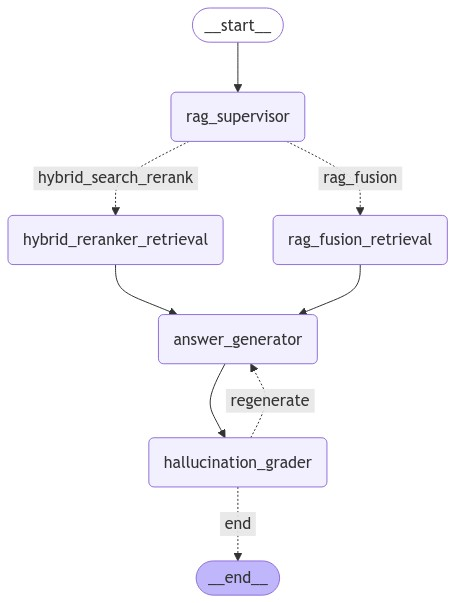

In [8]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph, START

# Initialise the graph
rag_workflow = StateGraph(GraphState)

# Add nodes
rag_workflow.add_node("rag_supervisor", rag_supervisor)
rag_workflow.add_node("hybrid_reranker_retrieval", hybrid_reranker_retrieval)
rag_workflow.add_node("rag_fusion_retrieval", rag_fusion_retrieval)
rag_workflow.add_node("answer_generator", answer_generator)
rag_workflow.add_node("hallucination_grader", hallucination_grader)

# Add Edges
rag_workflow.set_entry_point("rag_supervisor")
rag_workflow.add_conditional_edges(
    source="rag_supervisor",
    path=rag_supervisor_route,
    path_map={
        "hybrid_search_rerank": "hybrid_reranker_retrieval",
        "rag_fusion": "rag_fusion_retrieval"
    }
)
rag_workflow.add_edge("hybrid_reranker_retrieval", "answer_generator")
rag_workflow.add_edge("rag_fusion_retrieval", "answer_generator")
rag_workflow.add_edge("answer_generator", "hallucination_grader")
rag_workflow.add_conditional_edges(
    source="hallucination_grader",
    path=regenerate_route,
    path_map={
        "regenerate": "answer_generator",
        "end":END
    }
)
adaptive_rag = rag_workflow.compile()

display(Image(adaptive_rag.get_graph().draw_mermaid_png()))

In [9]:
question = "latency happen if too many features ? "
result = adaptive_rag.invoke({"question": question, "generate_count":0, "max_generate_count":2})

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [10]:
print(result['generation'])

Latency can indeed happen if too many features are used in a machine learning model. This is because having too many features can increase the memory required to serve a model, which can lead to higher latency. 

Here's a breakdown of how too many features can lead to higher latency:

1. **Increased memory requirements**: When a model has too many features, it requires more memory to store and process these features. This can lead to slower inference times, which can result in higher latency.
2. **Slower inference times**: With more features, the model takes longer to process each query, which can lead to slower inference times. This can be particularly problematic in applications with strict latency requirements.
3. **Overfitting and data leakage**: Having too many features can also lead to overfitting and data leakage, which can further exacerbate the latency issue.

To mitigate these issues, it's essential to carefully select the features used in the model and to perform ablation st

## 2.2 Generate answer and retrieve the referred context

In [11]:
import pandas as pd
import joblib

adaptive_rag_test = joblib.load(filename="test_cases.pkl")

INFO:numexpr.utils:NumExpr defaulting to 12 threads.


In [12]:
from tqdm import tqdm
import time

def answer_question_adaptive_rag(
    test_cases: dict,
    question_key: str,
    answer_key: str,
    doc_context_key: str,
) -> dict:
    test_cases[answer_key] = []
    test_cases[doc_context_key] = []

    for question in tqdm(test_cases[question_key], desc="Answering questions", total=len(test_cases[question_key])):
        result = adaptive_rag.invoke({"question": question, "generate_count":0, "max_generate_count":2})
        llm_answer = result['generation']
        doc_context = result['doc_context']
        time.sleep(5)

        test_cases[answer_key].append(llm_answer)
        test_cases[doc_context_key].append(doc_context)
    return test_cases


In [13]:
adaptive_rag_test = answer_question_adaptive_rag(
    test_cases=adaptive_rag_test,
    question_key="question",
    answer_key="adaptive_rag_answer",
    doc_context_key="adaptive_rag_doc_context",
)

Answering questions:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Answering questions:   5%|▌         | 1/20 [00:11<03:37, 11.46s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 4.000000 s

In [14]:
print(adaptive_rag_test['adaptive_rag_answer'][0])

**Data Distribution Shifts**

Data distribution shifts refer to changes in the underlying distribution of the data, which can affect the performance of machine learning models. These shifts can occur in various forms, including concept drift, covariate shift, and label shift.

**Types of Data Distribution Shifts**

1. **Covariate Shift**: This occurs when the distribution of the input data (X) changes, but the conditional probability of the output given the input (P(Y|X)) remains the same. In other words, the input data distribution changes, but the relationship between the input and output remains the same.
2. **Label Shift**: This occurs when the distribution of the output data (Y) changes, but the conditional probability of the input given the output (P(X|Y)) remains the same.
3. **Concept Drift**: This occurs when the conditional probability of the output given the input (P(Y|X)) changes, but the input data distribution (P(X)) remains the same.

**Causes of Data Distribution Shifts

In [15]:
from langchain_groq import ChatGroq
from deepeval.models.base_model import DeepEvalBaseLLM
from deepeval.metrics import ContextualPrecisionMetric, ContextualRecallMetric, ContextualRelevancyMetric, AnswerRelevancyMetric, FaithfulnessMetric
from deepeval.test_case import LLMTestCase
from tqdm import trange

class GroqLLM(DeepEvalBaseLLM):
    def __init__(
        self,
        model
    ):
        self.model = model

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        chat_model = self.load_model()
        return chat_model.invoke(prompt).content

    async def a_generate(self, prompt: str) -> str:
        chat_model = self.load_model()
        res = await chat_model.ainvoke(prompt)
        return res.content

    def get_model_name(self):
        return "Custom Azure OpenAI Model"

# Replace these with real values
custom_model = ChatGroq(
    model="gemma2-9b-it",
    temperature=0,
    api_key=config.GROQ_API_KEY
)
# Define Critic model
groq_critic_llm = GroqLLM(model=custom_model)

# Define all metrics
contextual_precision = ContextualPrecisionMetric(
    threshold=0.7,
    model=groq_critic_llm,
    include_reason=False
)

contextual_recall = ContextualRecallMetric(
    threshold=0.7,
    model=groq_critic_llm,
    include_reason=False    
)
contextual_relevancy = ContextualRelevancyMetric(
    threshold=0.7,
    model=groq_critic_llm,
    include_reason=False
)

answer_relevancy = AnswerRelevancyMetric(
    threshold=0.7,
    model=groq_critic_llm,
    include_reason=False
)

faithfulness = FaithfulnessMetric(
    threshold=0.7,
    model=groq_critic_llm,
    include_reason=False
)


def evaluate_rag(
    rag_test_cases: dict,
    answer_relevancy_key: str,
    faithfulness_key: str,
    contextual_precision_key: str,
    contextual_recall_key: str,
    contextual_relevancy_key: str,
    question_key: str,
    expected_answer_key: str,
    actual_answer_key: str,
    doc_context_key: str
) -> dict:

    rag_test_cases[answer_relevancy_key] = []
    rag_test_cases[faithfulness_key] = []
    rag_test_cases[contextual_precision_key] = []
    rag_test_cases[contextual_recall_key] = []
    rag_test_cases[contextual_relevancy_key] = []

    # Evaluate each test case
    for i in tqdm(range(len(rag_test_cases[question_key])), desc="Evaluating answers", total=len(rag_test_cases[question_key])):
        question = rag_test_cases[question_key][i]
        expected_answer = rag_test_cases[expected_answer_key][i]
        actual_answer = rag_test_cases[actual_answer_key][i]
        doc_context = rag_test_cases[doc_context_key][i]


        test_case = LLMTestCase(
            input=question,
            actual_output=actual_answer,
            expected_output=expected_answer,
            retrieval_context=[
                doc_context
            ]
        )

        try:
            answer_relevancy.measure(test_case)
            answer_relevancy_score = answer_relevancy.score
        except:
            answer_relevancy_score = -1
        time.sleep(20)

        try:
            faithfulness.measure(test_case)
            faithfulness_score = faithfulness.score
        except:
            faithfulness_score = -1
        time.sleep(20)   

        try:
            contextual_precision.measure(test_case)
            contextual_precision_score = contextual_precision.score
        except:
            contextual_precision_score = -1
        time.sleep(20)

        try:
            contextual_recall.measure(test_case)
            contextual_recall_score = contextual_recall.score
        except:
            contextual_recall_score = -1
        time.sleep(20)

        try:
            contextual_relevancy.measure(test_case)
            contextual_relevancy_score = contextual_relevancy.score
        except:
            contextual_relevancy_score = -1
        time.sleep(20)

        rag_test_cases[answer_relevancy_key].append(answer_relevancy_score)
        rag_test_cases[faithfulness_key].append(faithfulness_score)
        rag_test_cases[contextual_precision_key].append(contextual_precision_score)
        rag_test_cases[contextual_recall_key].append(contextual_recall_score)
        rag_test_cases[contextual_relevancy_key].append(contextual_relevancy_score)

        time.sleep(5)

    return rag_test_cases





c:\Users\jthxc\anaconda3\envs\jaredllm\Lib\site-packages\deepeval\__init__.py:49: UserWarning: You are using deepeval version 1.5.0, however version 1.5.4 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


In [16]:
adaptive_rag_test = evaluate_rag(
    rag_test_cases=adaptive_rag_test,
    answer_relevancy_key="answer_relevancy",
    faithfulness_key="faithfulness",
    contextual_precision_key="contextual_precision",
    contextual_recall_key="contextual_recall",
    contextual_relevancy_key="contextual_relevancy",
    question_key="question",
    expected_answer_key="expected_answer",
    actual_answer_key="adaptive_rag_answer",
    doc_context_key="adaptive_rag_doc_context"
)

Evaluating answers:   0%|          | 0/20 [00:00<?, ?it/s]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Evaluating answers:   5%|▌         | 1/20 [01:53<35:58, 113.63s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Evaluating answers:  10%|█         | 2/20 [03:45<33:44, 112.46s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Evaluating answers:  15%|█▌        | 3/20 [05:37<31:46, 112.16s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Evaluating answers:  20%|██        | 4/20 [07:28<29:50, 111.90s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Evaluating answers:  25%|██▌       | 5/20 [09:21<28:04, 112.31s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Evaluating answers:  30%|███       | 6/20 [11:13<26:08, 112.06s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Evaluating answers:  35%|███▌      | 7/20 [13:09<24:36, 113.54s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Evaluating answers:  40%|████      | 8/20 [15:01<22:34, 112.89s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Evaluating answers:  45%|████▌     | 9/20 [16:57<20:51, 113.80s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Evaluating answers:  50%|█████     | 10/20 [19:01<19:29, 116.97s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Evaluating answers:  55%|█████▌    | 11/20 [20:50<17:12, 114.72s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Evaluating answers:  60%|██████    | 12/20 [22:40<15:04, 113.12s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Evaluating answers:  65%|██████▌   | 13/20 [24:32<13:10, 112.91s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Evaluating answers:  70%|███████   | 14/20 [26:23<11:13, 112.27s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Evaluating answers:  75%|███████▌  | 15/20 [28:13<09:17, 111.50s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 54.000000 seconds


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Evaluating answers:  80%|████████  | 16/20 [30:55<08:26, 126.66s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Evaluating answers:  85%|████████▌ | 17/20 [32:42<06:02, 120.82s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Evaluating answers:  90%|█████████ | 18/20 [34:30<03:54, 117.12s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Evaluating answers:  95%|█████████▌| 19/20 [36:17<01:54, 114.14s/it]

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 5.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Evaluating answers: 100%|██████████| 20/20 [38:05<00:00, 114.25s/it]


In [17]:
adaptive_rag_test.keys()

dict_keys(['question', 'expected_answer', 'query_type', 'adaptive_rag_answer', 'adaptive_rag_doc_context', 'answer_relevancy', 'faithfulness', 'contextual_precision', 'contextual_recall', 'contextual_relevancy'])

In [18]:
import numpy as np

print(f"answer_relevancy: {np.average(adaptive_rag_test['answer_relevancy'])}")
print(f"faithfulness: {np.average(adaptive_rag_test['faithfulness'])}")
print(f"contextual_precision: {np.average(adaptive_rag_test['contextual_precision'])}")
print(f"contextual_recall: {np.average(adaptive_rag_test['contextual_recall'])}")
print(f"contextual_relevancy: {np.average(adaptive_rag_test['contextual_relevancy'])}")

answer_relevancy: 0.5944444444444444
faithfulness: 0.47750000000000004
contextual_precision: 0.38395833333333335
contextual_recall: 0.22999999999999998
contextual_relevancy: 0.2912545787545787


In [19]:
import joblib
joblib.dump(value=adaptive_rag_test, filename="adaptive_rag_test.pkl")

['adaptive_rag_test.pkl']